In [1]:
profileName = "fmv"

In [2]:
import boto3

my_session = boto3.Session(profile_name=profileName)
s3 = my_session.client('s3')
bucketName = "iotcore-home-export"
objectList = s3.list_objects(Bucket=bucketName)

In [4]:
import datetime
#更新されたのが1日以内のファイルをダウンロードする
for object in objectList["Contents"]:
    if ((datetime.datetime.now(datetime.timezone.utc) - object["LastModified"]).days < 1):
        s3.download_file(Bucket=bucketName,Key = object["Key"],Filename=("file/"+object["Key"]))

In [5]:
import pandas as pd
import glob

fileList = glob.glob("file/run-1683255843130**")

dfConcat = pd.DataFrame()

for file in fileList:
    df_ = pd.read_csv(file)
    dfConcat = pd.concat([dfConcat,df_])

In [7]:
dfConcat

,illuminance,deviceID,timeStamp
0,0.053980,picoW_5b,1683182118169
1,0.051563,picoW_5b,1683112633133
2,0.025782,picoW_5c,1683226954150
3,0.019336,picoW_5d,1683140121871
4,0.028199,picoW_5d,1683101179077
...,...,...,...
3596,2.766541,picoW_5c,1683157829553
3597,0.024170,picoW_5c,1683227674666
3598,0.030616,picoW_5d,1683103219025
3599,0.027393,picoW_5c,1683051262015


In [8]:
import datetime
import matplotlib.pyplot as plt

#データの成型
utc_day = [datetime.datetime.fromtimestamp(float(time)/1000).day for time in list(dfConcat["timeStamp"])]
utc_hour = [datetime.datetime.fromtimestamp(float(time)/1000).hour for time in list(dfConcat["timeStamp"])]
utc_second = [datetime.datetime.fromtimestamp(float(time)/1000).second for time in list(dfConcat["timeStamp"])]
utc_minute = [datetime.datetime.fromtimestamp(float(time)/1000).minute for time in list(dfConcat["timeStamp"])]

utc_floatHour = [datetime.datetime.fromtimestamp(float(time)/1000).minute/60 + datetime.datetime.fromtimestamp(float(time)/1000).hour for time in list(dfConcat["timeStamp"])]

dfConcat["utc_hour"] = utc_hour
dfConcat["utc_second"] = utc_second
dfConcat["utc_day"] = utc_day
dfConcat["utc_floatHour"] = utc_floatHour

dfConcat

,illuminance,deviceID,timeStamp,utc_hour,utc_second,utc_day,utc_floatHour
0,0.053980,picoW_5b,1683182118169,15,18,4,15.583333
1,0.051563,picoW_5b,1683112633133,20,13,3,20.283333
2,0.025782,picoW_5c,1683226954150,4,34,5,4.033333
3,0.019336,picoW_5d,1683140121871,3,21,4,3.916667
4,0.028199,picoW_5d,1683101179077,17,19,3,17.100000
...,...,...,...,...,...,...,...
3596,2.766541,picoW_5c,1683157829553,8,29,4,8.833333
3597,0.024170,picoW_5c,1683227674666,4,34,5,4.233333
3598,0.030616,picoW_5d,1683103219025,17,19,3,17.666667
3599,0.027393,picoW_5c,1683051262015,3,22,3,3.233333


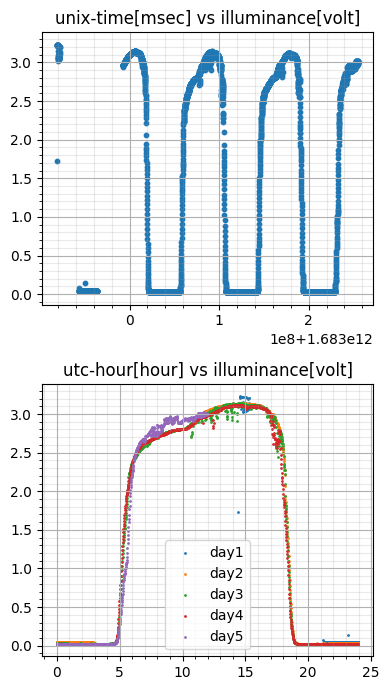

In [9]:
#グラフ描画
fig = plt.figure(figsize=(4,7))

v_Num = 2
h_Num = 1
graphNum = v_Num*h_Num

titles = ["unix-time[msec] vs illuminance[volt]","utc-hour[hour] vs illuminance[volt]"]

axDict = {}
for i in range((h_Num)):
    for ii in range((v_Num)):
        axDict["ax"+str(i*ii + ii)] = fig.add_subplot(graphNum,i+1,ii+1)
        axDict["ax"+str(i*ii + ii)].grid()
        axDict["ax"+str(i*ii + ii)].minorticks_on()
        axDict["ax"+str(i*ii + ii)].grid(True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        axDict["ax"+str(i*ii + ii)].set_title(titles[i*ii + ii])

axList = list(axDict.keys())

#fig1
deviceList = dfConcat["deviceID"].unique()
device=deviceList[1]
df_slice = dfConcat[dfConcat["deviceID"]==device]
axDict[axList[0]].scatter(df_slice["timeStamp"], df_slice["illuminance"],s=10)

#fig2
days = sorted (df_slice["utc_day"].unique())
for day in days:
    slice_of_slice = df_slice[df_slice["utc_day"]==day]
    axDict[axList[1]].scatter(slice_of_slice["utc_floatHour"], slice_of_slice["illuminance"],s=1)

axDict[axList[1]].legend(["day" + str(day) for day in days])

fig.tight_layout()
plt.show()